<a href="https://colab.research.google.com/github/blhuillier/2025B_AstroDataAnalysis/blob/main/Notebooks/Chap_7_Bayesian_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte-Carlo Integration

In [1]:
import pandas as pd
import ssl
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
print (pd.__version__)

# print (plt.rcParams)
mycols = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

2.2.2


## 1. We are interested in calculating
$$I=\int_0^1  {\sqrt{1-u^2}}\mathrm{d}u$$

1. Draw the integrand. What do you expect the answer will be? (do not calculate analytically!)

2. Numerically calculate $I$ with the Monte-Carlo method

3. Conclude

[ True False  True ...  True  True  True]
 Calculated: 0.7889
 Expected pi/4 = 0.7853981633974483


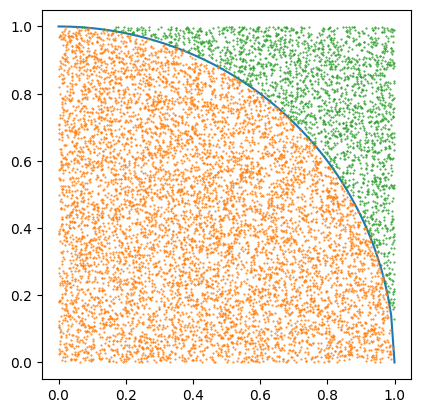

In [17]:
# 1.

uu = np.linspace(0,1,num=101)

def func(xx):
  return np.sqrt(1-xx**2)

fig, ax = plt.subplots(1)
ax.plot(uu, func(uu))
ax.set_aspect(1)

r = np.random.RandomState(42)

NN = 10_000
xx = r.uniform(0,1,NN)
yy = r.uniform(0,1,NN)


ii = yy < func(xx)
print (ii)

ax.plot(xx[ii],yy[ii],ls='',marker='.',markersize=1)
ax.plot(xx[True^ii],yy[True^ii],ls='',marker='.',markersize=1)

# True ^ ii is the XOR operator
# 0 OR 1 = 1
# 0 OR 0 = 0
# 1 OR 1 = 1

# XOR:
# 0 XOR 0 = 0
# 1 XOR 1 = 0
# 0 XOR 1 = 1

# 1-ii

print (f" Calculated: {ii.sum() / NN}")
print (f" Expected pi/4 = {np.pi/4}")


## 2. Let us consider  $$I=\int_{-1}^{1} \cos 2\pi t \mathrm d t$$





### 2.1 Plot the function & guess the area

### 2.2 Calculate it using the Monte-Carlo Method

# 3. Model Selection

In Assignment 3, we performed MCMC on the Pantheon dataset.

The [Data]("https://raw.githubusercontent.com/dscolnic/Pantheon/master/lcparam_full_long.txt")
and the systematics part of the covariance matrix are [here](https://raw.githubusercontent.com/dscolnic/Pantheon/master/sys_full_long.txt)

Among the following models, which model fits the Pantheon supernovae compilation better? why?
$\Lambda$CDM, Flat $\Lambda$CDM, $w$CDM, Flat $w$CDM

### 3.1 Which tools do you know can compare these models?

## 3.2 Calculate them and rank the models.

# 4. MCMC with DESI DR2 data


The DESI DR2 BAO data can be found [here](https://raw.githubusercontent.com/blhuillier/Olympiades/refs/heads/main/Data/DESI_DR2.csv).


The data are:

$\begin{align}
\frac{d_M(z)}{r_d}, \frac {d_H}{r_d}, \mathrm{ where}\\
d_H(z) & = \frac {c}{H(z)}, \\
d_M(z) & = \int_0^z \frac {c}{H(z')} \mathrm d z'\\
H^2(z) & = H_0^2 (\Omega_m (1+z)^3 + (1-\Omega_m).
\end{align}$

We will assume that $r_d = 1\, \mathrm{Mpc}$.


1. Use the Astropy.cosmology class to write the likelihood for the Flat-LCDM model.  
2. using the emcee code, run an MCMC

In [39]:
filein = "https://raw.githubusercontent.com/blhuillier/Olympiades/refs/heads/main/Data/DESI_DR2.csv"
DESI = pd.read_csv(filein, sep=',')
DESI.drop(columns=['DV/rd', 'err_DV/rd', 'DM/DH', 'err_DM/DH'],index=0, inplace=True)
DESI.reset_index(drop=True, inplace=True)

from astropy.cosmology import FlatLambdaCDM

DESI

,Tracer,z_eff,"rV,M/H",DM/rd,err_DM/rd,DH/rd,err_DH/rd,"rM,H"
0,LRG1,0.510,0.050,13.588,0.167,21.863,0.425,-0.459
1,LRG2,0.706,-0.018,17.351,0.177,19.455,0.330,-0.404
2,LRG3+ELG1,0.934,0.056,21.576,0.152,17.641,0.193,-0.416
3,ELG2,1.321,0.202,27.601,0.318,14.176,0.221,-0.434
4,QSO,1.484,0.044,30.512,0.760,12.817,0.516,-0.500
5,Lya,2.330,0.574,38.988,0.531,8.632,0.101,-0.431
6,LRG3,0.922,0.106,21.648,0.178,17.577,0.213,-0.406
7,ELG1,0.955,0.420,21.707,0.335,17.803,0.297,-0.462


In [50]:
rd = 143.7 # Mpc

NN = len(DESI)
cov = np.zeros((len(DESI),2,2))
inv_cov = np.zeros((len(DESI),2,2))
for ii in range(NN):
  # define the ii-th covariance matrix
  cov[ii,0,0] = DESI.loc[ii,'err_DM/rd']**2
  cov[ii,1,1] = DESI.loc[ii,'err_DH/rd']**2
  cov [ii, 0,1] = DESI.loc[ii,'err_DH/rd'] * DESI.loc[ii,'err_DM/rd'] * DESI.loc[ii,'rM,H']
  # invert the ii-th covariance matrix
  inv_cov[ii,:,:] = np.linalg.inv(cov[ii,:,:])





# define the prior:

def ln_pi(theta):

  Om0, hh = theta # h = H0/100 km/s/Mpc

  res = -np.inf

  if 0 < Om0 < 1 and 0.5 < hh < 1:
    res = 0

# define the likelihood:

def ln_L(theta, DESI, inv_cov):

  # (dM, dH):
  Om0, hh = theta

  thiscosmo = FlatLambdaCDM(Om0=Om0, H0=100*hh)
  dM = thiscosmo.comoving_transverse_distance(DESI['z_eff'])
  dH = thiscosmo.comoving_distance(DESI['z_eff'])
  model = np.vstack([dM,dH]) / rd
  print (model.shape)

  residuals = model - DESI[['DM/rd', 'DH/rd']].values

  chi2 = (residuals.T @ inv_cov @ residuals).sum()

  return - 2 * chi2

# define the posterior:
def ln_p(theta, DESI, inv_cov):
  lpi = ln_pi(theta)
  if np.isfinite(lpi):
    return lpi + ln_L(theta,DESI,inv_cov)
  return lpi


In [51]:
Om0 = 0.3
H0 = 70

theta = (Om0,H0)
print (ln_L(theta,DESI,inv_cov))

(2, 8)


UnitConversionError: Can only apply 'subtract' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan).